In [1]:
# # check version
# !pip list | grep pettingzoo


In [2]:
# !pip install pettingzoo==1.22.0

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
import magent2
import os
import gymnasium as gym

In [2]:
from magent2.environments import battle_v4

In [3]:
from tqdm import tqdm

In [4]:
# set cuda visible devices
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


# Model

In [5]:
class BlueAgent(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
        )
        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]
        self.network = nn.Sequential(
            nn.Linear(flatten_dim, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, action_shape),
        )

    def forward(self, x):
        assert len(x.shape) >= 3, "only support magent input observation"
        x = self.cnn(x)
        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]
        x = x.reshape(batchsize, -1)
        return self.network(x)


In [6]:
class RedAgent(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
        )
        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]
        self.network = nn.Sequential(
            nn.Linear(flatten_dim, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, action_shape),
        )

    def forward(self, x):
        assert len(x.shape) >= 3, "only support magent input observation"
        x = self.cnn(x)
        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]
        x = x.reshape(batchsize, -1)
        return self.network(x)


# Init game

In [9]:
env = battle_v4.env(map_size=45, max_cycles=300, render_mode="rgb_array", step_reward=0.001,
dead_penalty=-0.1, attack_penalty=-0.05, attack_opponent_reward=0.5,extra_features=False)

# env = battle_v4.env(map_size=45, max_cycles=300, render_mode="rgb_array")



In [10]:
env.reset()

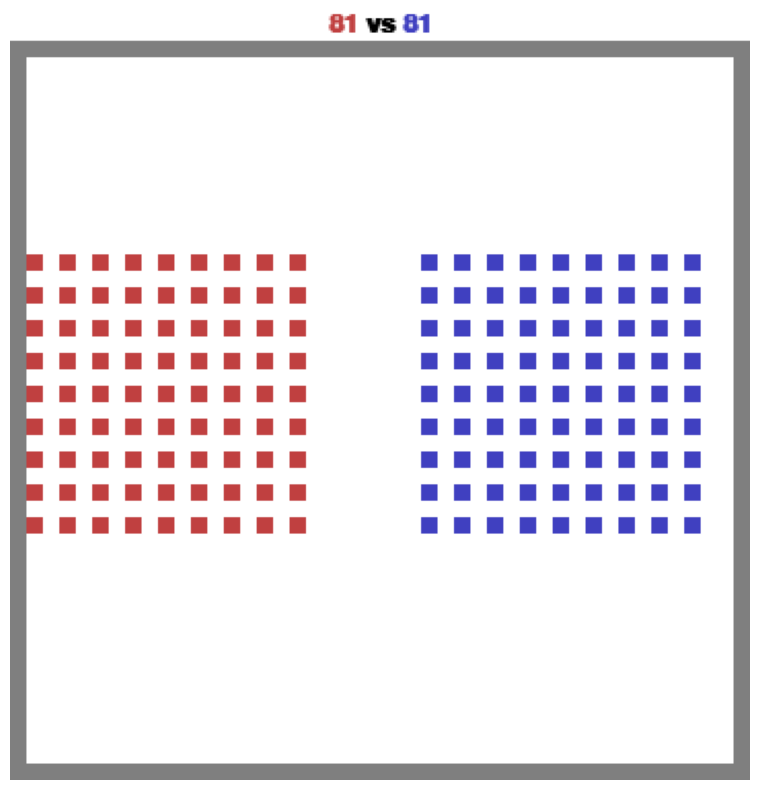

In [11]:
def render_game_image(env):
    plt.figure(figsize=(10, 10))
    plt.imshow(env.render())
    plt.axis('off')
    plt.show()

render_game_image(env)

In [12]:
import cv2
import os
def record_game_video(frames, vid_dir="videos", video_name="random2", fps=5):
    height, width, _ = frames[0].shape
    out = cv2.VideoWriter(
        os.path.join(vid_dir, video_name),
        cv2.VideoWriter_fourcc(*"mp4v"),
        fps,
        (width, height),
    )
    for frame in frames:
        # Convert BGR to RGB since OpenCV uses BGR by default
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)
    out.release()




# Agent and parameters setup

In [13]:

observation_shape = env.observation_space("red_0").shape
action_shape = env.action_space("red_0").n
red_weight_path = "red.pt"
blue_weight_path = None


In [14]:
q_network = BlueAgent(observation_shape, action_shape)
if blue_weight_path is not None: 
    q_network.load_state_dict(torch.load(blue_weight_path, weights_only=True))
target_q_network = BlueAgent(observation_shape, action_shape)
target_q_network.load_state_dict(q_network.state_dict())
opponent_agent = RedAgent(observation_shape, action_shape)
if red_weight_path is not None:
    opponent_agent.load_state_dict(torch.load(red_weight_path, weights_only=True))


In [15]:
gamma = 0.99 
batch_size = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(q_network.parameters(), lr=0.001)
criterion = nn.MSELoss()
epsilon = 1 # epsilon greedy policy
epsilon_decay = 0.99
epsilon_min = 0.1
tau = 0.95 # soft update
max_episodes = 300


In [16]:
device 

device(type='cuda')

In [17]:
q_network.to(device)
target_q_network.to(device)
opponent_agent.to(device)

RedAgent(
  (cnn): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (network): Sequential(
    (0): Linear(in_features=405, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=21, bias=True)
  )
)

In [18]:
q_network

BlueAgent(
  (cnn): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (network): Sequential(
    (0): Linear(in_features=405, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=21, bias=True)
  )
)

In [19]:
from collections import defaultdict, deque
class RelayBuffer():
    """ 
    Store data of blue agent
    data include: observation, action, next_observation, reward, done
    """
    def __init__(self, observation_shape, action_shape, capacity=100000):
        self.storage = []
        self.capacity = capacity
        self.observation_shape = observation_shape
        self.action_shape = action_shape
        self.data = deque(maxlen=capacity)
    
    def add(self, data_samples):
        self.data.append(data_samples)
    
    def sample(self, batch_size):
        return random.sample(self.data, batch_size)
    
    def __len__(self):
        return len(self.data)
    
    def reset(self):
        self.data.clear()
    
    def get_all_data(self):
        return self.data
    

In [20]:
# replay_buffer = ReplayBuffer(observation_shape, action_shape, capacity=100000, batch_size=64, device=device)
relay_buffer = RelayBuffer(observation_shape, action_shape, capacity= 200000)


## Test Play game and gather data

In [21]:
# create prev data to store data of prev cycle 
# env last to get current data
# use prev_data[agent][obs], prev_data[agent][action], prev_data[agent][reward], current_data[agent][obs], to update relay buffer
# if this check turn agent died, then update prev_data[agent][done] = True

In [22]:
frames = []
env.reset()
prev_data = defaultdict(list)  #obs, action
for agent in env.agent_iter():
    observation, reward, termination, truncation, info = env.last()
    agent_team = agent.split('_')[0]
    done = False
    # check if agent died and get action
    if termination or truncation:
        action = None  # this agent has died
        done = True
    else:
        action = env.action_space(agent).sample()
    
    #if exist prev data, add to relay buffer
    try:
        if agent in prev_data:
            relay_buffer.add((prev_data[agent][0], prev_data[agent][1], observation, reward, done))
    except Exception as e:
        print(prev_data[agent])
        print(e)
        break
    
    # if agent died, reset prev data
    if termination or truncation:
        prev_data[agent] = None
    else:
        prev_data[agent] = [observation, action]
    
    # step game
    env.step(action) 
    
    # record frame
    if agent == "red_0":
        frames.append(env.render())
print(len(frames))

301


In [23]:
record_game_video(frames, vid_dir="video", video_name="test_15_12.mp4")

# Training

In [24]:
def get_q_value(agent: nn.Module, observation: torch.Tensor, batch_size: int= 1024, device: torch.device= device):
    if len(observation.shape) == 3: # single observation
        if isinstance(observation, np.ndarray):
            observation = torch.tensor(observation, dtype=torch.float32, device=device).permute(2, 0, 1)
        else:
            observation = observation.clone().detach().requires_grad_(False).permute(2, 0, 1)
        q_values = agent(observation)
    else: # batch observation
        if isinstance(observation, np.ndarray):
            observation = torch.tensor(observation, dtype=torch.float32, device=device).permute(0, 3, 1, 2)
        else:
            observation = observation.clone().detach().requires_grad_(False).permute(0, 3, 1, 2)
        num_batches = (observation.shape[0] + batch_size - 1) // batch_size
        q_values = []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, observation.shape[0])
            batch_observation = observation[start_idx:end_idx]
            batch_observation = batch_observation.to(device)
            batch_q_values = agent(batch_observation)
            q_values.append(batch_q_values)
        # print("batch_q_values", batch_q_values.shape)
        
        q_values = torch.cat(q_values)
    return q_values
    


In [25]:
def predict_action(agent: nn.Module, observation: torch.Tensor, batch_size: int= 1024):
    with torch.no_grad():
        agent.eval()
        q_values = get_q_value(agent, observation, batch_size)
        return q_values.argmax(dim=1).item()
    


In [26]:
from torch.utils.data import DataLoader

In [27]:
def train(agent: nn.Module, target_agent: nn.Module, data: list):
    agent.train()
    # #copy data
    # data = data.copy()
    #shuffle data
    random.shuffle(data)
    
    #convert to np 
    state, action, next_state, reward, done = zip(*data)
    state = np.array(state)
    action = np.array(action)
    next_state = np.array(next_state)
    reward = np.array(reward)
    done = np.array(done)
    
    #convert to torch tensor
    state = torch.tensor(state, dtype=torch.float32, device=device)
    action = torch.tensor(action, dtype=torch.long, device=device)
    next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
    reward = torch.tensor(reward, dtype=torch.float32, device=device)
    done = torch.tensor(done, dtype=torch.float32, device=device) 
    
    # calculate old_value, Process in smaller batches to avoid OOM
    old_q_values = get_q_value(agent, state, batch_size)
        
    # calculate target q value
    next_q_values = get_q_value(target_agent, next_state, batch_size)
    
    # predict value and target value
    try:
        predict = old_q_values.gather(1, action.unsqueeze(1)).squeeze(1) 
    except Exception as e:
        print(old_q_values.shape)
        print(old_q_values)
        print(action.shape)
        print(e)
        raise e
    next_max_q_value = next_q_values.max(dim=1).values
    target = reward + gamma * next_max_q_value * (1 - done)
    
    # calculate loss
    loss = criterion(predict, target)
    
    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
    


In [28]:
def get_blue_agent_action(agent_id: str, agent: nn.Module, observation: torch.Tensor, epsilon: float, env: gym.Env):
    if np.random.rand() < epsilon:
        action = env.action_space(agent_id).sample()
    else:
        action = predict_action(agent=agent, observation=observation)
    return action

def get_red_agent_action(agent_id: str, env: gym.Env):
    return env.action_space(agent_id).sample()


In [29]:
# max_episodes = 100

In [30]:
pbar = tqdm(range(max_episodes), position=0, leave=True, desc="Training")
relay_buffer.reset()
for episode in pbar:
    
    # epsilon decay
    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    
    # reset env
    env.reset()
    
    rewards = [0, 0] # red reward, blue reward
    cycle_count = 0
    last_agent_team = None
    
    #store data of prev cycle
    prev_data = defaultdict(list)  #obs, action of blue agent
    for agent_id in env.agent_iter():
        
        observation, reward, termination, truncation, info = env.last()
        agent_team = agent_id.split('_')[0]
        
        if agent_team == "blue":
            #get action
            if termination or truncation:
                action = None # this agent has died
                done = True
            else:
                action = get_blue_agent_action(agent_id ,q_network, observation, epsilon, env)
            
            # add data to relay buffer
            try:
                if agent_id in prev_data:
                    relay_buffer.add((prev_data[agent_id][0], prev_data[agent_id][1], observation, reward, done))
            except Exception as e:
                print(prev_data[agent_id])
                print(e)
                break
            
            # update prev data
            if termination or truncation:
                del prev_data[agent_id]   #delete agent from prev data
            else:
                prev_data[agent_id] = [observation, action]
        
        else: #red agent_id (random)
            if termination or truncation:
                action = None # this agent_id has died
            else:
                action = env.action_space(agent_id).sample()
            
        env.step(action)
        rewards[0] += reward if agent_team == "red" else 0
        rewards[1] += reward if agent_team == "blue" else 0
        
        if agent_team != last_agent_team and agent_team == "red":
            # frames.append(env.render())
            cycle_count += 1
        last_agent_team = agent_team
        
    #training
    data = relay_buffer.get_all_data()
    train(q_network, target_q_network, data)
    
    # soft update target network
    for param, target_param in zip(q_network.parameters(), target_q_network.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
    
            
    pbar.set_description(f"Episode {episode}")
    print(f"Episode {episode} done, step length: {cycle_count}, red reward: {rewards[0]}, blue reward: {rewards[1]}, epsilon: {epsilon:.3f}")
    
    


Episode 0:   0%|          | 1/300 [00:04<24:35,  4.93s/it]

Episode 0 done, step length: 301, red reward: -349.37102059973404, blue reward: -329.30002074944787, epsilon: 0.990


Episode 1:   1%|          | 2/300 [00:07<16:24,  3.31s/it]

Episode 1 done, step length: 301, red reward: -367.4000208771322, blue reward: -356.150020351517, epsilon: 0.980


Episode 2:   1%|          | 3/300 [00:10<15:41,  3.17s/it]

Episode 2 done, step length: 301, red reward: -377.06702091847546, blue reward: -359.2500207015546, epsilon: 0.970


Episode 3:   1%|▏         | 4/300 [00:13<16:50,  3.41s/it]

Episode 3 done, step length: 301, red reward: -370.7500207646517, blue reward: -341.350019683945, epsilon: 0.961


Episode 4:   2%|▏         | 5/300 [00:18<19:09,  3.90s/it]

Episode 4 done, step length: 301, red reward: -380.7500215981854, blue reward: -351.8880196638638, epsilon: 0.951


Episode 5:   2%|▏         | 6/300 [00:24<22:11,  4.53s/it]

Episode 5 done, step length: 301, red reward: -350.5260204344522, blue reward: -324.450019596261, epsilon: 0.941


Episode 6:   2%|▏         | 7/300 [00:31<25:51,  5.29s/it]

Episode 6 done, step length: 301, red reward: -343.937020280282, blue reward: -322.50001949910074, epsilon: 0.932


Episode 7:   3%|▎         | 8/300 [00:40<31:55,  6.56s/it]

Episode 7 done, step length: 301, red reward: -334.0900204878999, blue reward: -311.2750192886451, epsilon: 0.923


Episode 8:   3%|▎         | 9/300 [00:51<38:45,  7.99s/it]

Episode 8 done, step length: 301, red reward: -275.6670199134387, blue reward: -256.43701870786026, epsilon: 0.914


Episode 9:   3%|▎         | 10/300 [01:00<39:16,  8.13s/it]

Episode 9 done, step length: 301, red reward: -280.43501966586336, blue reward: -254.00501812901348, epsilon: 0.904


Episode 10:   4%|▎         | 11/300 [01:08<39:50,  8.27s/it]

Episode 10 done, step length: 301, red reward: -264.7720212956192, blue reward: -226.4180171546759, epsilon: 0.895


Episode 11:   4%|▍         | 12/300 [01:17<40:18,  8.40s/it]

Episode 11 done, step length: 301, red reward: -253.15002017177176, blue reward: -238.65401686064433, epsilon: 0.886


Episode 12:   4%|▍         | 13/300 [01:25<40:23,  8.44s/it]

Episode 12 done, step length: 301, red reward: -253.16901967918966, blue reward: -214.93301828380208, epsilon: 0.878


Episode 13:   5%|▍         | 14/300 [01:34<40:45,  8.55s/it]

Episode 13 done, step length: 301, red reward: -331.000020198524, blue reward: -287.4500176793663, epsilon: 0.869


Episode 14:   5%|▌         | 15/300 [01:43<40:56,  8.62s/it]

Episode 14 done, step length: 301, red reward: -381.2500210084254, blue reward: -324.60001788893715, epsilon: 0.860


Episode 15:   5%|▌         | 16/300 [01:52<41:37,  8.79s/it]

Episode 15 done, step length: 301, red reward: -418.2140217637643, blue reward: -341.45001840020996, epsilon: 0.851


Episode 16:   6%|▌         | 17/300 [02:01<41:46,  8.86s/it]

Episode 16 done, step length: 301, red reward: -399.43602119141724, blue reward: -326.7500183522934, epsilon: 0.843


Episode 17:   6%|▌         | 18/300 [02:10<42:01,  8.94s/it]

Episode 17 done, step length: 301, red reward: -396.3020211957628, blue reward: -320.3500178029062, epsilon: 0.835


Episode 18:   6%|▋         | 19/300 [02:20<42:21,  9.05s/it]

Episode 18 done, step length: 301, red reward: -404.7210212625796, blue reward: -330.2500184219098, epsilon: 0.826


Episode 19:   7%|▋         | 20/300 [02:29<42:22,  9.08s/it]

Episode 19 done, step length: 301, red reward: -426.0500218960224, blue reward: -339.45001758111175, epsilon: 0.818


Episode 20:   7%|▋         | 21/300 [02:38<42:55,  9.23s/it]

Episode 20 done, step length: 301, red reward: -433.8500220401911, blue reward: -345.30001750588417, epsilon: 0.810


Episode 21:   7%|▋         | 22/300 [02:48<43:37,  9.41s/it]

Episode 21 done, step length: 301, red reward: -422.11502171389293, blue reward: -331.0500174629269, epsilon: 0.802


Episode 22:   8%|▊         | 23/300 [02:58<43:54,  9.51s/it]

Episode 22 done, step length: 301, red reward: -437.2000220150221, blue reward: -344.5000173437875, epsilon: 0.794


Episode 23:   8%|▊         | 24/300 [03:08<44:03,  9.58s/it]

Episode 23 done, step length: 301, red reward: -409.67402154789306, blue reward: -317.3500170422485, epsilon: 0.786


Episode 24:   8%|▊         | 25/300 [03:18<44:22,  9.68s/it]

Episode 24 done, step length: 301, red reward: -428.95002209290396, blue reward: -331.65001694799867, epsilon: 0.778


Episode 25:   9%|▊         | 26/300 [03:28<44:30,  9.75s/it]

Episode 25 done, step length: 301, red reward: -350.9000213192776, blue reward: -278.42101596470457, epsilon: 0.770


Episode 26:   9%|▉         | 27/300 [03:38<44:42,  9.83s/it]

Episode 26 done, step length: 301, red reward: -222.64802066306584, blue reward: -161.07101417821832, epsilon: 0.762


Episode 27:   9%|▉         | 28/300 [03:48<44:56,  9.91s/it]

Episode 27 done, step length: 301, red reward: -229.29801986610983, blue reward: -140.1150156946387, epsilon: 0.755


Episode 28:  10%|▉         | 29/300 [03:58<45:00,  9.96s/it]

Episode 28 done, step length: 301, red reward: -281.5740198302083, blue reward: -186.11401617480442, epsilon: 0.747


Episode 29:  10%|█         | 30/300 [04:08<45:06, 10.02s/it]

Episode 29 done, step length: 301, red reward: -256.91302036552224, blue reward: -181.81301499856636, epsilon: 0.740


Episode 30:  10%|█         | 31/300 [04:18<45:07, 10.06s/it]

Episode 30 done, step length: 301, red reward: -265.46502042142674, blue reward: -177.11501489102375, epsilon: 0.732


Episode 31:  11%|█         | 32/300 [04:28<45:06, 10.10s/it]

Episode 31 done, step length: 301, red reward: -270.7660198529484, blue reward: -172.85401570179965, epsilon: 0.725


Episode 32:  11%|█         | 33/300 [04:39<45:35, 10.25s/it]

Episode 32 done, step length: 301, red reward: -250.92102119501214, blue reward: -174.11901446455158, epsilon: 0.718


Episode 33:  11%|█▏        | 34/300 [04:50<46:31, 10.49s/it]

Episode 33 done, step length: 301, red reward: -239.82101895811502, blue reward: -151.01701452757698, epsilon: 0.711


Episode 34:  12%|█▏        | 35/300 [05:01<47:17, 10.71s/it]

Episode 34 done, step length: 301, red reward: -349.50002153241076, blue reward: -235.8150139079662, epsilon: 0.703


Episode 35:  12%|█▏        | 36/300 [05:12<47:42, 10.84s/it]

Episode 35 done, step length: 301, red reward: -374.30002099392004, blue reward: -240.15001396054868, epsilon: 0.696


Episode 36:  12%|█▏        | 37/300 [05:23<47:50, 10.91s/it]

Episode 36 done, step length: 301, red reward: -378.51902127393987, blue reward: -263.753014490474, epsilon: 0.689


Episode 37:  13%|█▎        | 38/300 [05:35<48:12, 11.04s/it]

Episode 37 done, step length: 301, red reward: -416.2020219778642, blue reward: -254.1500140678836, epsilon: 0.683


Episode 38:  13%|█▎        | 39/300 [05:46<48:13, 11.09s/it]

Episode 38 done, step length: 301, red reward: -393.7500213518506, blue reward: -261.70001400401816, epsilon: 0.676


Episode 39:  13%|█▎        | 40/300 [05:57<48:22, 11.16s/it]

Episode 39 done, step length: 301, red reward: -398.35002128419, blue reward: -260.7500138693722, epsilon: 0.669


Episode 40:  14%|█▎        | 41/300 [06:09<49:07, 11.38s/it]

Episode 40 done, step length: 301, red reward: -382.80102108221035, blue reward: -232.90001370757818, epsilon: 0.662


Episode 41:  14%|█▍        | 42/300 [06:21<49:25, 11.49s/it]

Episode 41 done, step length: 301, red reward: -365.00002082739957, blue reward: -235.6500132997753, epsilon: 0.656


Episode 42:  14%|█▍        | 43/300 [06:33<50:02, 11.68s/it]

Episode 42 done, step length: 301, red reward: -351.4500203967327, blue reward: -232.05001312040258, epsilon: 0.649


Episode 43:  15%|█▍        | 44/300 [06:45<50:08, 11.75s/it]

Episode 43 done, step length: 301, red reward: -311.4000204477925, blue reward: -187.77401244698558, epsilon: 0.643


Episode 44:  15%|█▌        | 45/300 [06:57<50:08, 11.80s/it]

Episode 44 done, step length: 301, red reward: -332.68902032764163, blue reward: -197.30001329933293, epsilon: 0.636


Episode 45:  15%|█▌        | 46/300 [07:09<49:56, 11.80s/it]

Episode 45 done, step length: 301, red reward: -383.4500212612329, blue reward: -236.03301277349237, epsilon: 0.630


Episode 46:  16%|█▌        | 47/300 [07:21<50:30, 11.98s/it]

Episode 46 done, step length: 301, red reward: -423.4640215714462, blue reward: -252.7500134567963, epsilon: 0.624


Episode 47:  16%|█▌        | 48/300 [07:33<50:35, 12.05s/it]

Episode 47 done, step length: 301, red reward: -438.80002198996954, blue reward: -260.6000130411703, epsilon: 0.617


Episode 48:  16%|█▋        | 49/300 [07:45<50:25, 12.05s/it]

Episode 48 done, step length: 301, red reward: -419.48502137325704, blue reward: -243.10001297597773, epsilon: 0.611


Episode 49:  17%|█▋        | 50/300 [07:57<50:11, 12.05s/it]

Episode 49 done, step length: 301, red reward: -421.09302155452315, blue reward: -238.55001336394344, epsilon: 0.605


Episode 50:  17%|█▋        | 51/300 [08:10<50:12, 12.10s/it]

Episode 50 done, step length: 301, red reward: -415.00002150260843, blue reward: -243.80001258826815, epsilon: 0.599


Episode 51:  17%|█▋        | 52/300 [08:22<50:17, 12.17s/it]

Episode 51 done, step length: 301, red reward: -398.43802122899797, blue reward: -215.20001268945634, epsilon: 0.593


Episode 52:  18%|█▊        | 53/300 [08:35<50:45, 12.33s/it]

Episode 52 done, step length: 301, red reward: -367.05402076162864, blue reward: -196.35001290624496, epsilon: 0.587


Episode 53:  18%|█▊        | 54/300 [08:47<51:14, 12.50s/it]

Episode 53 done, step length: 301, red reward: -378.6000215644017, blue reward: -221.71101179427933, epsilon: 0.581


Episode 54:  18%|█▊        | 55/300 [09:00<51:13, 12.54s/it]

Episode 54 done, step length: 301, red reward: -424.3500217589317, blue reward: -233.80001195031218, epsilon: 0.575


Episode 55:  19%|█▊        | 56/300 [09:13<51:28, 12.66s/it]

Episode 55 done, step length: 301, red reward: -420.80002173921093, blue reward: -230.05001185077708, epsilon: 0.570


Episode 56:  19%|█▉        | 57/300 [09:26<51:28, 12.71s/it]

Episode 56 done, step length: 301, red reward: -428.85002166882623, blue reward: -232.9500117507996, epsilon: 0.564


Episode 57:  19%|█▉        | 58/300 [09:39<52:08, 12.93s/it]

Episode 57 done, step length: 301, red reward: -417.60002166708, blue reward: -217.35001134022605, epsilon: 0.558


Episode 58:  20%|█▉        | 59/300 [09:53<52:38, 13.11s/it]

Episode 58 done, step length: 301, red reward: -288.85002071072813, blue reward: -148.39901007618755, epsilon: 0.553


Episode 59:  20%|██        | 60/300 [10:06<52:15, 13.06s/it]

Episode 59 done, step length: 301, red reward: -161.28902183880564, blue reward: -80.17500915960409, epsilon: 0.547


Episode 60:  20%|██        | 61/300 [10:19<52:05, 13.08s/it]

Episode 60 done, step length: 301, red reward: -132.81301924900617, blue reward: -39.768010274739936, epsilon: 0.542


Episode 61:  21%|██        | 62/300 [10:33<52:30, 13.24s/it]

Episode 61 done, step length: 301, red reward: -230.45902149984613, blue reward: -133.00900980015285, epsilon: 0.536


Episode 62:  21%|██        | 63/300 [10:46<52:38, 13.32s/it]

Episode 62 done, step length: 301, red reward: -393.5940211483976, blue reward: -203.4500112972455, epsilon: 0.531


Episode 63:  21%|██▏       | 64/300 [11:00<52:48, 13.42s/it]

Episode 63 done, step length: 301, red reward: -433.80002181068994, blue reward: -218.9000110332854, epsilon: 0.526


Episode 64:  22%|██▏       | 65/300 [11:13<52:58, 13.53s/it]

Episode 64 done, step length: 301, red reward: -419.33002155751456, blue reward: -202.8500109530287, epsilon: 0.520


Episode 65:  22%|██▏       | 66/300 [11:27<52:45, 13.53s/it]

Episode 65 done, step length: 301, red reward: -420.45002145983744, blue reward: -215.45001089631114, epsilon: 0.515


Episode 66:  22%|██▏       | 67/300 [11:41<53:13, 13.70s/it]

Episode 66 done, step length: 301, red reward: -428.4500217536697, blue reward: -206.5000105376821, epsilon: 0.510


Episode 67:  23%|██▎       | 68/300 [11:55<52:48, 13.66s/it]

Episode 67 done, step length: 301, red reward: -436.8500219102716, blue reward: -206.1500103805447, epsilon: 0.505


Episode 68:  23%|██▎       | 69/300 [12:08<52:34, 13.65s/it]

Episode 68 done, step length: 301, red reward: -410.5500213332707, blue reward: -189.8500101271784, epsilon: 0.500


Episode 69:  23%|██▎       | 70/300 [12:23<53:25, 13.94s/it]

Episode 69 done, step length: 301, red reward: -364.6690210204106, blue reward: -176.30701013328508, epsilon: 0.495


Episode 70:  24%|██▎       | 71/300 [12:37<53:30, 14.02s/it]

Episode 70 done, step length: 301, red reward: -253.80902015895117, blue reward: -98.80000951874536, epsilon: 0.490


Episode 71:  24%|██▍       | 72/300 [12:51<53:14, 14.01s/it]

Episode 71 done, step length: 301, red reward: -188.20002111257054, blue reward: -103.17100841086358, epsilon: 0.485


Episode 72:  24%|██▍       | 73/300 [13:05<53:06, 14.04s/it]

Episode 72 done, step length: 301, red reward: -359.9000209958758, blue reward: -161.32700926077086, epsilon: 0.480


Episode 73:  25%|██▍       | 74/300 [13:20<53:26, 14.19s/it]

Episode 73 done, step length: 301, red reward: -415.30002156994306, blue reward: -184.85000972088892, epsilon: 0.475


Episode 74:  25%|██▌       | 75/300 [13:34<53:24, 14.24s/it]

Episode 74 done, step length: 301, red reward: -441.8500222990988, blue reward: -195.4000098973047, epsilon: 0.471


Episode 75:  25%|██▌       | 76/300 [13:48<53:11, 14.25s/it]

Episode 75 done, step length: 301, red reward: -426.500021743821, blue reward: -190.0500096481992, epsilon: 0.466


Episode 76:  26%|██▌       | 77/300 [14:03<53:49, 14.48s/it]

Episode 76 done, step length: 301, red reward: -428.500021756161, blue reward: -186.3000095661264, epsilon: 0.461


Episode 77:  26%|██▌       | 78/300 [14:18<53:50, 14.55s/it]

Episode 77 done, step length: 301, red reward: -388.95002106030006, blue reward: -157.70000897930004, epsilon: 0.457


Episode 78:  26%|██▋       | 79/300 [14:33<53:42, 14.58s/it]

Episode 78 done, step length: 301, red reward: -298.3500198988477, blue reward: -101.25000822718721, epsilon: 0.452


Episode 79:  27%|██▋       | 80/300 [14:48<54:12, 14.78s/it]

Episode 79 done, step length: 301, red reward: -280.9000197763089, blue reward: -72.05500852223486, epsilon: 0.448


Episode 80:  27%|██▋       | 81/300 [15:03<54:28, 14.92s/it]

Episode 80 done, step length: 301, red reward: -232.31901876209304, blue reward: 0.8799915079725906, epsilon: 0.443


Episode 81:  27%|██▋       | 82/300 [15:18<54:10, 14.91s/it]

Episode 81 done, step length: 301, red reward: -244.90201963263098, blue reward: -8.002010068623349, epsilon: 0.439


Episode 82:  28%|██▊       | 83/300 [15:33<54:09, 14.97s/it]

Episode 82 done, step length: 301, red reward: -312.70201974443626, blue reward: -47.71301138459239, epsilon: 0.434


Episode 83:  28%|██▊       | 84/300 [15:48<54:04, 15.02s/it]

Episode 83 done, step length: 301, red reward: -405.3860211734427, blue reward: -155.9000099617988, epsilon: 0.430


Episode 84:  28%|██▊       | 85/300 [16:04<53:55, 15.05s/it]

Episode 84 done, step length: 301, red reward: -435.23802193114534, blue reward: -161.10000906488858, epsilon: 0.426


Episode 85:  29%|██▊       | 86/300 [16:20<55:29, 15.56s/it]

Episode 85 done, step length: 301, red reward: -420.40902150655165, blue reward: -165.6500091518974, epsilon: 0.421


Episode 86:  29%|██▉       | 87/300 [16:36<54:56, 15.47s/it]

Episode 86 done, step length: 301, red reward: -439.95002218696754, blue reward: -165.55000849731732, epsilon: 0.417


Episode 87:  29%|██▉       | 88/300 [16:51<54:12, 15.34s/it]

Episode 87 done, step length: 301, red reward: -423.1000216442626, blue reward: -161.80000831047073, epsilon: 0.413


Episode 88:  30%|██▉       | 89/300 [17:06<54:02, 15.37s/it]

Episode 88 done, step length: 301, red reward: -394.92402106372174, blue reward: -125.15001009555999, epsilon: 0.409


Episode 89:  30%|███       | 90/300 [17:21<53:40, 15.33s/it]

Episode 89 done, step length: 301, red reward: -141.99801496730652, blue reward: 142.79897401027847, epsilon: 0.405


Episode 90:  30%|███       | 91/300 [17:36<52:58, 15.21s/it]

Episode 90 done, step length: 301, red reward: -74.33101206622086, blue reward: 245.06297179614194, epsilon: 0.401


Episode 91:  31%|███       | 92/300 [17:51<52:07, 15.04s/it]

Episode 91 done, step length: 301, red reward: -49.498008821043186, blue reward: 277.59997139754705, epsilon: 0.397


Episode 92:  31%|███       | 93/300 [18:05<50:41, 14.69s/it]

Episode 92 done, step length: 301, red reward: -37.876007272163406, blue reward: 310.8599700832274, epsilon: 0.393


Episode 93:  31%|███▏      | 94/300 [18:19<49:48, 14.51s/it]

Episode 93 done, step length: 301, red reward: -220.00901553721633, blue reward: 149.12397726229392, epsilon: 0.389


Episode 94:  32%|███▏      | 95/300 [18:33<49:12, 14.40s/it]

Episode 94 done, step length: 301, red reward: -409.50102106283884, blue reward: -89.5500103229424, epsilon: 0.385


Episode 95:  32%|███▏      | 96/300 [18:47<48:47, 14.35s/it]

Episode 95 done, step length: 301, red reward: -434.8500219503185, blue reward: -172.35000908060465, epsilon: 0.381


Episode 96:  32%|███▏      | 97/300 [19:01<48:25, 14.31s/it]

Episode 96 done, step length: 301, red reward: -395.32302047731355, blue reward: -137.75001543120015, epsilon: 0.377


Episode 97:  33%|███▎      | 98/300 [19:16<48:00, 14.26s/it]

Episode 97 done, step length: 301, red reward: -317.98601778014563, blue reward: -5.621021043159999, epsilon: 0.373


Episode 98:  33%|███▎      | 99/300 [19:30<48:12, 14.39s/it]

Episode 98 done, step length: 301, red reward: -342.4510184110841, blue reward: 33.499984960537404, epsilon: 0.370


Episode 99:  33%|███▎      | 100/300 [19:45<48:06, 14.43s/it]

Episode 99 done, step length: 301, red reward: -367.01301935396623, blue reward: -12.05001368036028, epsilon: 0.366


Episode 100:  34%|███▎      | 101/300 [20:00<48:11, 14.53s/it]

Episode 100 done, step length: 301, red reward: -429.42202162370086, blue reward: -143.3000080906786, epsilon: 0.362


Episode 101:  34%|███▍      | 102/300 [20:15<48:31, 14.71s/it]

Episode 101 done, step length: 301, red reward: -433.6680217619287, blue reward: -146.80000879243016, epsilon: 0.359


Episode 102:  34%|███▍      | 103/300 [20:30<48:32, 14.79s/it]

Episode 102 done, step length: 301, red reward: -184.1600128461141, blue reward: 196.55797389126383, epsilon: 0.355


Episode 103:  35%|███▍      | 104/300 [20:45<49:02, 15.01s/it]

Episode 103 done, step length: 301, red reward: -108.47900796076283, blue reward: 215.849966675858, epsilon: 0.352


Episode 104:  35%|███▌      | 105/300 [21:00<49:07, 15.11s/it]

Episode 104 done, step length: 301, red reward: -122.44300837430637, blue reward: 267.24996588064823, epsilon: 0.348


Episode 105:  35%|███▌      | 106/300 [21:16<49:13, 15.22s/it]

Episode 105 done, step length: 301, red reward: -316.9100172856124, blue reward: 70.64997697330546, epsilon: 0.345


Episode 106:  36%|███▌      | 107/300 [21:32<49:20, 15.34s/it]

Episode 106 done, step length: 301, red reward: -299.8560165108647, blue reward: 197.6499764105538, epsilon: 0.341


Episode 107:  36%|███▌      | 108/300 [21:47<49:17, 15.40s/it]

Episode 107 done, step length: 301, red reward: -290.2590166364098, blue reward: 111.33898151572794, epsilon: 0.338


Episode 108:  36%|███▋      | 109/300 [22:03<49:17, 15.48s/it]

Episode 108 done, step length: 301, red reward: -424.7900214375695, blue reward: -116.25000802462455, epsilon: 0.334


Episode 109:  37%|███▋      | 110/300 [22:18<49:07, 15.51s/it]

Episode 109 done, step length: 301, red reward: -433.7140217118431, blue reward: -128.1000076511409, epsilon: 0.331


Episode 110:  37%|███▋      | 111/300 [22:34<48:56, 15.53s/it]

Episode 110 done, step length: 301, red reward: -434.89102175668813, blue reward: -130.70000725332648, epsilon: 0.328


Episode 111:  37%|███▋      | 112/300 [22:50<48:56, 15.62s/it]

Episode 111 done, step length: 301, red reward: -348.206018250552, blue reward: 11.999984891619533, epsilon: 0.324


Episode 112:  38%|███▊      | 113/300 [23:05<48:37, 15.60s/it]

Episode 112 done, step length: 301, red reward: -191.60701116663404, blue reward: 163.19997349963523, epsilon: 0.321


Episode 113:  38%|███▊      | 114/300 [23:21<48:39, 15.70s/it]

Episode 113 done, step length: 301, red reward: -149.57100895082112, blue reward: 312.3999759987928, epsilon: 0.318


Episode 114:  38%|███▊      | 115/300 [23:37<48:46, 15.82s/it]

Episode 114 done, step length: 301, red reward: -344.9690185028594, blue reward: -10.15001794777345, epsilon: 0.315


Episode 115:  39%|███▊      | 116/300 [23:53<48:34, 15.84s/it]

Episode 115 done, step length: 301, red reward: -431.3330217709299, blue reward: -75.10000767861493, epsilon: 0.312


Episode 116:  39%|███▉      | 117/300 [24:09<48:23, 15.87s/it]

Episode 116 done, step length: 301, red reward: -434.28502170171123, blue reward: -96.65000680356752, epsilon: 0.309


Episode 117:  39%|███▉      | 118/300 [24:26<48:34, 16.01s/it]

Episode 117 done, step length: 301, red reward: -437.41402194520924, blue reward: -111.50000742124394, epsilon: 0.305


Episode 118:  40%|███▉      | 119/300 [24:42<48:23, 16.04s/it]

Episode 118 done, step length: 301, red reward: -433.40002165106125, blue reward: -131.75000672589522, epsilon: 0.302


Episode 119:  40%|████      | 120/300 [24:58<48:05, 16.03s/it]

Episode 119 done, step length: 301, red reward: -434.3710217017215, blue reward: -90.10000696964562, epsilon: 0.299


Episode 120:  40%|████      | 121/300 [25:14<47:44, 16.00s/it]

Episode 120 done, step length: 301, red reward: -253.64701364864595, blue reward: 348.3499779192498, epsilon: 0.296


Episode 121:  41%|████      | 122/300 [25:25<43:34, 14.69s/it]

Episode 121 done, step length: 171, red reward: -119.38200674939435, blue reward: 434.2699725332204, epsilon: 0.293


Episode 122:  41%|████      | 123/300 [25:41<44:21, 15.04s/it]

Episode 122 done, step length: 301, red reward: -252.73901384556666, blue reward: 197.09996975096874, epsilon: 0.290


Episode 123:  41%|████▏     | 124/300 [25:57<44:42, 15.24s/it]

Episode 123 done, step length: 301, red reward: -403.5090203777654, blue reward: -342.60002532368526, epsilon: 0.288


Episode 124:  42%|████▏     | 125/300 [26:11<43:57, 15.07s/it]

Episode 124 done, step length: 301, red reward: -320.1710168526042, blue reward: 180.74998478160705, epsilon: 0.285


Episode 125:  42%|████▏     | 126/300 [26:26<43:37, 15.04s/it]

Episode 125 done, step length: 301, red reward: -365.06801879720297, blue reward: 99.94998822954949, epsilon: 0.282


Episode 126:  42%|████▏     | 127/300 [26:41<43:11, 14.98s/it]

Episode 126 done, step length: 301, red reward: -254.63401420239825, blue reward: 261.7289766559843, epsilon: 0.279


Episode 127:  43%|████▎     | 128/300 [26:57<43:26, 15.15s/it]

Episode 127 done, step length: 301, red reward: -427.5370213863207, blue reward: -243.40001386753283, epsilon: 0.276


Episode 128:  43%|████▎     | 129/300 [27:12<43:17, 15.19s/it]

Episode 128 done, step length: 301, red reward: -422.6050211425172, blue reward: -160.55001207592431, epsilon: 0.273


Episode 129:  43%|████▎     | 130/300 [27:28<43:34, 15.38s/it]

Episode 129 done, step length: 301, red reward: -397.82002004713286, blue reward: 18.349987970548682, epsilon: 0.271


Episode 130:  44%|████▎     | 131/300 [27:44<43:33, 15.47s/it]

Episode 130 done, step length: 301, red reward: -203.51101066439878, blue reward: 294.8499818473356, epsilon: 0.268


Episode 131:  44%|████▍     | 132/300 [27:59<42:51, 15.31s/it]

Episode 131 done, step length: 301, red reward: -152.86300792056136, blue reward: 380.94997722806875, epsilon: 0.265


Episode 132:  44%|████▍     | 133/300 [28:14<42:38, 15.32s/it]

Episode 132 done, step length: 301, red reward: -431.53602161363233, blue reward: -84.60000674799085, epsilon: 0.263


Episode 133:  45%|████▍     | 134/300 [28:29<42:35, 15.39s/it]

Episode 133 done, step length: 301, red reward: -411.34402071055956, blue reward: -149.85001364874188, epsilon: 0.260


Episode 134:  45%|████▌     | 135/300 [28:45<42:36, 15.50s/it]

Episode 134 done, step length: 301, red reward: -430.58002156950533, blue reward: -111.00000741379336, epsilon: 0.257


Episode 135:  45%|████▌     | 136/300 [29:01<42:38, 15.60s/it]

Episode 135 done, step length: 301, red reward: -430.82802153541707, blue reward: -52.00000638794154, epsilon: 0.255


Episode 136:  46%|████▌     | 137/300 [29:17<42:24, 15.61s/it]

Episode 136 done, step length: 301, red reward: -443.2560221386375, blue reward: -88.80000520055182, epsilon: 0.252


Episode 137:  46%|████▌     | 138/300 [29:33<43:01, 15.94s/it]

Episode 137 done, step length: 301, red reward: -444.00002217199653, blue reward: -80.10000532935373, epsilon: 0.250


Episode 138:  46%|████▋     | 139/300 [29:50<43:26, 16.19s/it]

Episode 138 done, step length: 301, red reward: -155.99900825275108, blue reward: 296.299969535321, epsilon: 0.247


Episode 139:  47%|████▋     | 140/300 [30:06<42:57, 16.11s/it]

Episode 139 done, step length: 301, red reward: -274.05001507373527, blue reward: 210.88998284330592, epsilon: 0.245


Episode 140:  47%|████▋     | 141/300 [30:23<43:00, 16.23s/it]

Episode 140 done, step length: 301, red reward: -417.3400208550738, blue reward: -31.400006521027535, epsilon: 0.242


Episode 141:  47%|████▋     | 142/300 [30:39<43:00, 16.33s/it]

Episode 141 done, step length: 301, red reward: -427.71902139438316, blue reward: -35.95000620291103, epsilon: 0.240


Episode 142:  48%|████▊     | 143/300 [30:56<43:05, 16.47s/it]

Episode 142 done, step length: 301, red reward: -435.5270217672223, blue reward: -74.35000495554414, epsilon: 0.238


Episode 143:  48%|████▊     | 144/300 [31:13<42:54, 16.50s/it]

Episode 143 done, step length: 301, red reward: -395.2130198695231, blue reward: 9.899990835925564, epsilon: 0.235


Episode 144:  48%|████▊     | 145/300 [31:29<42:31, 16.46s/it]

Episode 144 done, step length: 301, red reward: -132.9500071152579, blue reward: 421.9999754631426, epsilon: 0.233


Episode 145:  49%|████▊     | 146/300 [31:46<42:43, 16.64s/it]

Episode 145 done, step length: 301, red reward: -191.58801002590917, blue reward: 352.49997816444375, epsilon: 0.231


Episode 146:  49%|████▉     | 147/300 [32:04<43:21, 17.00s/it]

Episode 146 done, step length: 301, red reward: -426.9270213423297, blue reward: -74.4000045878347, epsilon: 0.228


Episode 147:  49%|████▉     | 148/300 [32:21<43:34, 17.20s/it]

Episode 147 done, step length: 301, red reward: -409.63102067273576, blue reward: 0.34999355219770223, epsilon: 0.226


Episode 148:  50%|████▉     | 149/300 [32:38<43:04, 17.12s/it]

Episode 148 done, step length: 301, red reward: -304.18001544789877, blue reward: 274.79998379945755, epsilon: 0.224


Episode 149:  50%|█████     | 150/300 [32:55<42:41, 17.08s/it]

Episode 149 done, step length: 301, red reward: -254.50501325691584, blue reward: 435.19997592875734, epsilon: 0.221


Episode 150:  50%|█████     | 151/300 [33:12<42:11, 16.99s/it]

Episode 150 done, step length: 301, red reward: -193.41301019792445, blue reward: 349.8499737122329, epsilon: 0.219


Episode 151:  51%|█████     | 152/300 [33:29<41:47, 16.94s/it]

Episode 151 done, step length: 301, red reward: -198.23101030953694, blue reward: 344.3499808002962, epsilon: 0.217


Episode 152:  51%|█████     | 153/300 [33:46<41:29, 16.94s/it]

Episode 152 done, step length: 301, red reward: -222.17401153303217, blue reward: 336.94998250261415, epsilon: 0.215


Episode 153:  51%|█████▏    | 154/300 [34:03<41:10, 16.92s/it]

Episode 153 done, step length: 301, red reward: -440.300021994859, blue reward: -76.65000396303367, epsilon: 0.213


Episode 154:  52%|█████▏    | 155/300 [34:20<40:57, 16.95s/it]

Episode 154 done, step length: 301, red reward: -437.2950218518963, blue reward: -274.4000155203976, epsilon: 0.211


Episode 155:  52%|█████▏    | 156/300 [34:36<40:26, 16.85s/it]

Episode 155 done, step length: 301, red reward: -272.1850139792077, blue reward: 133.09996895794757, epsilon: 0.208


Episode 156:  52%|█████▏    | 157/300 [34:53<39:43, 16.67s/it]

Episode 156 done, step length: 301, red reward: -223.36901142075658, blue reward: 346.7999809188768, epsilon: 0.206


Episode 157:  53%|█████▎    | 158/300 [35:09<39:21, 16.63s/it]

Episode 157 done, step length: 301, red reward: -371.6580187663203, blue reward: 105.09999032667838, epsilon: 0.204


Episode 158:  53%|█████▎    | 159/300 [35:26<39:00, 16.60s/it]

Episode 158 done, step length: 301, red reward: -341.84001729730517, blue reward: 119.84998959826771, epsilon: 0.202


Episode 159:  53%|█████▎    | 160/300 [35:42<38:32, 16.51s/it]

Episode 159 done, step length: 301, red reward: -370.94001876178663, blue reward: 103.69999041059054, epsilon: 0.200


Episode 160:  54%|█████▎    | 161/300 [35:59<38:28, 16.60s/it]

Episode 160 done, step length: 301, red reward: -356.5090179843828, blue reward: 146.69998860312626, epsilon: 0.198


Episode 161:  54%|█████▍    | 162/300 [36:16<38:29, 16.74s/it]

Episode 161 done, step length: 301, red reward: -437.42502184433397, blue reward: -51.95000394422095, epsilon: 0.196


Episode 162:  54%|█████▍    | 163/300 [36:33<38:18, 16.78s/it]

Episode 162 done, step length: 301, red reward: -427.0070213661529, blue reward: -30.500004649627954, epsilon: 0.194


Episode 163:  55%|█████▍    | 164/300 [36:50<38:29, 16.98s/it]

Episode 163 done, step length: 301, red reward: -431.516021567164, blue reward: -53.900003988994285, epsilon: 0.192


Episode 164:  55%|█████▌    | 165/300 [37:08<38:45, 17.23s/it]

Episode 164 done, step length: 301, red reward: -390.76101960858796, blue reward: 44.04999262129422, epsilon: 0.190


Episode 165:  55%|█████▌    | 166/300 [37:21<35:19, 15.82s/it]

Episode 165 done, step length: 173, red reward: -115.99800659692846, blue reward: 467.7819744121516, epsilon: 0.189


Episode 166:  56%|█████▌    | 167/300 [37:38<35:57, 16.22s/it]

Episode 166 done, step length: 301, red reward: -88.54700499854516, blue reward: 464.3499773776857, epsilon: 0.187


Episode 167:  56%|█████▌    | 168/300 [37:55<36:27, 16.57s/it]

Episode 167 done, step length: 301, red reward: -324.34901652263943, blue reward: 74.49998525367118, epsilon: 0.185


Episode 168:  56%|█████▋    | 169/300 [38:13<36:48, 16.86s/it]

Episode 168 done, step length: 301, red reward: -386.370019512251, blue reward: -184.150018591783, epsilon: 0.183


Episode 169:  57%|█████▋    | 170/300 [38:30<37:08, 17.15s/it]

Episode 169 done, step length: 301, red reward: -430.1590215199394, blue reward: -171.9000123795122, epsilon: 0.181


Episode 170:  57%|█████▋    | 171/300 [38:48<37:09, 17.28s/it]

Episode 170 done, step length: 301, red reward: -410.3600205697585, blue reward: -72.95000976824667, epsilon: 0.179


Episode 171:  57%|█████▋    | 172/300 [39:06<37:16, 17.47s/it]

Episode 171 done, step length: 301, red reward: -422.13002111192327, blue reward: 4.899994676467031, epsilon: 0.178


Episode 172:  58%|█████▊    | 173/300 [39:24<37:08, 17.54s/it]

Episode 172 done, step length: 301, red reward: -332.011016865843, blue reward: 261.9999873281922, epsilon: 0.176


Episode 173:  58%|█████▊    | 174/300 [39:41<36:37, 17.44s/it]

Episode 173 done, step length: 301, red reward: -120.97500638337806, blue reward: 381.74997191049624, epsilon: 0.174


Episode 174:  58%|█████▊    | 175/300 [39:59<36:38, 17.59s/it]

Episode 174 done, step length: 301, red reward: -427.4890214080224, blue reward: -14.45000407693442, epsilon: 0.172


Episode 175:  59%|█████▊    | 176/300 [40:16<36:15, 17.55s/it]

Episode 175 done, step length: 301, red reward: -434.4800217320444, blue reward: -47.35000369756017, epsilon: 0.171


Episode 176:  59%|█████▉    | 177/300 [40:33<35:44, 17.43s/it]

Episode 176 done, step length: 301, red reward: -426.1050212897826, blue reward: -40.25000453821849, epsilon: 0.169


Episode 177:  59%|█████▉    | 178/300 [40:51<35:30, 17.46s/it]

Episode 177 done, step length: 301, red reward: -400.6170200203778, blue reward: -3.250008331495337, epsilon: 0.167


Episode 178:  60%|█████▉    | 179/300 [41:08<35:15, 17.48s/it]

Episode 178 done, step length: 301, red reward: -446.0630222747568, blue reward: -85.75000562833156, epsilon: 0.165


Episode 179:  60%|██████    | 180/300 [41:26<34:54, 17.45s/it]

Episode 179 done, step length: 301, red reward: -400.0330201103352, blue reward: 57.34999396849889, epsilon: 0.164


Episode 180:  60%|██████    | 181/300 [41:44<35:08, 17.72s/it]

Episode 180 done, step length: 301, red reward: -293.81101522792596, blue reward: 258.09998848545365, epsilon: 0.162


Episode 181:  61%|██████    | 182/300 [42:03<35:14, 17.92s/it]

Episode 181 done, step length: 301, red reward: -385.07501936296467, blue reward: 83.79999237018637, epsilon: 0.161


Episode 182:  61%|██████    | 183/300 [42:21<35:17, 18.10s/it]

Episode 182 done, step length: 301, red reward: -434.9920217578765, blue reward: -116.70000706566498, epsilon: 0.159


Episode 183:  61%|██████▏   | 184/300 [42:40<35:10, 18.20s/it]

Episode 183 done, step length: 301, red reward: -443.01202212262433, blue reward: -44.45000348321628, epsilon: 0.157


Episode 184:  62%|██████▏   | 185/300 [42:58<34:54, 18.22s/it]

Episode 184 done, step length: 301, red reward: -429.3020214494318, blue reward: -21.950003626407124, epsilon: 0.156


Episode 185:  62%|██████▏   | 186/300 [43:16<34:34, 18.20s/it]

Episode 185 done, step length: 301, red reward: -437.4940218862612, blue reward: -45.600002978229895, epsilon: 0.154


Episode 186:  62%|██████▏   | 187/300 [43:35<34:49, 18.49s/it]

Episode 186 done, step length: 301, red reward: -439.0210219275905, blue reward: -56.600003473926336, epsilon: 0.153


Episode 187:  63%|██████▎   | 188/300 [43:53<34:25, 18.44s/it]

Episode 187 done, step length: 301, red reward: -153.95900844456628, blue reward: 495.0999760844279, epsilon: 0.151


Episode 188:  63%|██████▎   | 189/300 [44:13<34:29, 18.64s/it]

Episode 188 done, step length: 301, red reward: -366.6110186325386, blue reward: 101.39998701307923, epsilon: 0.150


Episode 189:  63%|██████▎   | 190/300 [44:31<34:08, 18.62s/it]

Episode 189 done, step length: 301, red reward: -432.56502163328696, blue reward: -37.350003779050894, epsilon: 0.148


Episode 190:  64%|██████▎   | 191/300 [44:50<33:51, 18.64s/it]

Episode 190 done, step length: 301, red reward: -425.94802134891506, blue reward: -12.650003672926687, epsilon: 0.147


Episode 191:  64%|██████▍   | 192/300 [45:08<33:27, 18.59s/it]

Episode 191 done, step length: 301, red reward: -439.19102195324376, blue reward: -70.45000423386227, epsilon: 0.145


Episode 192:  64%|██████▍   | 193/300 [45:27<33:13, 18.63s/it]

Episode 192 done, step length: 301, red reward: -428.6080214843387, blue reward: -71.10000614519231, epsilon: 0.144


Episode 193:  65%|██████▍   | 194/300 [45:45<32:42, 18.52s/it]

Episode 193 done, step length: 301, red reward: -417.26702095603105, blue reward: 4.949994696420617, epsilon: 0.142


Episode 194:  65%|██████▌   | 195/300 [46:04<32:32, 18.60s/it]

Episode 194 done, step length: 301, red reward: -304.1050156998681, blue reward: 289.2499858919764, epsilon: 0.141


Episode 195:  65%|██████▌   | 196/300 [46:23<32:30, 18.75s/it]

Episode 195 done, step length: 301, red reward: -305.41601561463904, blue reward: 231.1999878261704, epsilon: 0.139


Episode 196:  66%|██████▌   | 197/300 [46:42<31:58, 18.63s/it]

Episode 196 done, step length: 301, red reward: -432.53902164509054, blue reward: -10.000003153225407, epsilon: 0.138


Episode 197:  66%|██████▌   | 198/300 [47:00<31:39, 18.62s/it]

Episode 197 done, step length: 301, red reward: -426.3080213518115, blue reward: -2.1000055884942412, epsilon: 0.137


Episode 198:  66%|██████▋   | 199/300 [47:19<31:26, 18.67s/it]

Episode 198 done, step length: 301, red reward: -371.6160186935449, blue reward: 38.3999904259108, epsilon: 0.135


Episode 199:  67%|██████▋   | 200/300 [47:38<31:20, 18.81s/it]

Episode 199 done, step length: 301, red reward: -423.377021163702, blue reward: -2.700003879144788, epsilon: 0.134


Episode 200:  67%|██████▋   | 201/300 [47:57<30:57, 18.77s/it]

Episode 200 done, step length: 301, red reward: -403.4120202329941, blue reward: 56.64999498834368, epsilon: 0.133


Episode 201:  67%|██████▋   | 202/300 [48:15<30:37, 18.75s/it]

Episode 201 done, step length: 301, red reward: -115.47800650866702, blue reward: 485.24997647025157, epsilon: 0.131


Episode 202:  68%|██████▊   | 203/300 [48:34<30:02, 18.58s/it]

Episode 202 done, step length: 301, red reward: -116.18500637181569, blue reward: 491.8499771169154, epsilon: 0.130


Episode 203:  68%|██████▊   | 204/300 [48:45<26:29, 16.56s/it]

Episode 203 done, step length: 135, red reward: -90.02100508986041, blue reward: 551.5539786457084, epsilon: 0.129


Episode 204:  68%|██████▊   | 205/300 [49:04<27:05, 17.11s/it]

Episode 204 done, step length: 301, red reward: -188.14900982636027, blue reward: 403.0499817378586, epsilon: 0.127


Episode 205:  69%|██████▊   | 206/300 [49:23<27:43, 17.69s/it]

Episode 205 done, step length: 301, red reward: -254.83101294387598, blue reward: 331.299985650694, epsilon: 0.126


Episode 206:  69%|██████▉   | 207/300 [49:41<27:48, 17.94s/it]

Episode 206 done, step length: 301, red reward: -391.89101971685886, blue reward: 79.99999404582195, epsilon: 0.125


Episode 207:  69%|██████▉   | 208/300 [50:00<27:46, 18.12s/it]

Episode 207 done, step length: 301, red reward: -435.14002179249655, blue reward: -4.8000027544330806, epsilon: 0.124


Episode 208:  70%|██████▉   | 209/300 [50:18<27:31, 18.15s/it]

Episode 208 done, step length: 301, red reward: -424.08802119945176, blue reward: 4.699996524490416, epsilon: 0.122


Episode 209:  70%|███████   | 210/300 [50:37<27:29, 18.33s/it]

Episode 209 done, step length: 301, red reward: -405.49002030142583, blue reward: 84.49999349471182, epsilon: 0.121


Episode 210:  70%|███████   | 211/300 [50:55<27:10, 18.32s/it]

Episode 210 done, step length: 301, red reward: -359.7330183592858, blue reward: 32.49998915055767, epsilon: 0.120


Episode 211:  71%|███████   | 212/300 [51:13<26:50, 18.30s/it]

Episode 211 done, step length: 301, red reward: -180.53400964278262, blue reward: 492.64998018124606, epsilon: 0.119


Episode 212:  71%|███████   | 213/300 [51:32<26:35, 18.33s/it]

Episode 212 done, step length: 301, red reward: -336.4640170604689, blue reward: -73.85002077242825, epsilon: 0.118


Episode 213:  71%|███████▏  | 214/300 [51:50<26:02, 18.17s/it]

Episode 213 done, step length: 301, red reward: -245.67701259197202, blue reward: 294.04997790989, epsilon: 0.116


Episode 214:  72%|███████▏  | 215/300 [52:08<25:57, 18.32s/it]

Episode 214 done, step length: 301, red reward: -254.59801306889858, blue reward: 411.1999825211242, epsilon: 0.115


Episode 215:  72%|███████▏  | 216/300 [52:26<25:32, 18.25s/it]

Episode 215 done, step length: 301, red reward: -195.55201023514383, blue reward: 351.9999797041528, epsilon: 0.114


Episode 216:  72%|███████▏  | 217/300 [52:44<25:00, 18.07s/it]

Episode 216 done, step length: 301, red reward: -419.4580210694112, blue reward: -22.650005662464537, epsilon: 0.113


Episode 217:  73%|███████▎  | 218/300 [53:02<24:31, 17.95s/it]

Episode 217 done, step length: 301, red reward: -402.7430202597752, blue reward: 52.849996063276194, epsilon: 0.112


Episode 218:  73%|███████▎  | 219/300 [53:20<24:12, 17.94s/it]

Episode 218 done, step length: 301, red reward: -421.2290210905485, blue reward: 13.699996868148446, epsilon: 0.111


Episode 219:  73%|███████▎  | 220/300 [53:37<23:42, 17.79s/it]

Episode 219 done, step length: 301, red reward: -424.0470212738728, blue reward: 6.649997623986565, epsilon: 0.110


Episode 220:  74%|███████▎  | 221/300 [53:54<23:15, 17.67s/it]

Episode 220 done, step length: 301, red reward: -424.0630212748656, blue reward: 37.69999604532495, epsilon: 0.108


Episode 221:  74%|███████▍  | 222/300 [54:12<22:51, 17.58s/it]

Episode 221 done, step length: 301, red reward: -431.8360215969151, blue reward: -22.200003094039857, epsilon: 0.107


Episode 222:  74%|███████▍  | 223/300 [54:31<23:02, 17.96s/it]

Episode 222 done, step length: 301, red reward: -436.41702180786524, blue reward: -7.750002321670763, epsilon: 0.106


Episode 223:  75%|███████▍  | 224/300 [54:49<22:45, 17.97s/it]

Episode 223 done, step length: 301, red reward: -279.8510149947833, blue reward: 287.23298601887655, epsilon: 0.105


Episode 224:  75%|███████▌  | 225/300 [55:07<22:33, 18.05s/it]

Episode 224 done, step length: 301, red reward: -434.60402170347515, blue reward: -14.250001961016096, epsilon: 0.104


Episode 225:  75%|███████▌  | 226/300 [55:24<22:03, 17.89s/it]

Episode 225 done, step length: 301, red reward: -188.7370098627871, blue reward: 330.8999823932536, epsilon: 0.103


Episode 226:  76%|███████▌  | 227/300 [55:42<21:48, 17.93s/it]

Episode 226 done, step length: 301, red reward: -134.2330070878379, blue reward: 490.2499781617662, epsilon: 0.102


Episode 227:  76%|███████▌  | 228/300 [56:01<21:50, 18.20s/it]

Episode 227 done, step length: 301, red reward: -411.5300206847023, blue reward: 37.99999309168197, epsilon: 0.101


Episode 228:  76%|███████▋  | 229/300 [56:20<21:39, 18.30s/it]

Episode 228 done, step length: 301, red reward: -428.4170213951729, blue reward: -18.200002297526225, epsilon: 0.100


Episode 229:  77%|███████▋  | 230/300 [56:38<21:24, 18.35s/it]

Episode 229 done, step length: 301, red reward: -433.93002169101965, blue reward: -12.900001401314512, epsilon: 0.100


Episode 230:  77%|███████▋  | 231/300 [56:57<21:17, 18.51s/it]

Episode 230 done, step length: 301, red reward: -435.59202179138083, blue reward: -18.3500015855534, epsilon: 0.100


Episode 231:  77%|███████▋  | 232/300 [57:16<21:08, 18.66s/it]

Episode 231 done, step length: 301, red reward: -285.57201446499676, blue reward: 259.0999867192004, epsilon: 0.100


Episode 232:  78%|███████▊  | 233/300 [57:35<20:51, 18.68s/it]

Episode 232 done, step length: 301, red reward: -267.5330138338031, blue reward: 205.79998483881354, epsilon: 0.100


Episode 233:  78%|███████▊  | 234/300 [57:53<20:25, 18.57s/it]

Episode 233 done, step length: 301, red reward: -321.53301634604577, blue reward: 108.09998725960031, epsilon: 0.100


Episode 234:  78%|███████▊  | 235/300 [58:12<20:02, 18.50s/it]

Episode 234 done, step length: 301, red reward: -436.70502182957716, blue reward: -18.750001588021405, epsilon: 0.100


Episode 235:  79%|███████▊  | 236/300 [58:30<19:50, 18.59s/it]

Episode 235 done, step length: 301, red reward: -417.01402087160386, blue reward: 0.6999973799102008, epsilon: 0.100


Episode 236:  79%|███████▉  | 237/300 [58:49<19:27, 18.53s/it]

Episode 236 done, step length: 301, red reward: -413.7780206911266, blue reward: 45.59999643894844, epsilon: 0.100


Episode 237:  79%|███████▉  | 238/300 [59:07<19:00, 18.40s/it]

Episode 237 done, step length: 301, red reward: -438.1000218852423, blue reward: -34.55000184790697, epsilon: 0.100


Episode 238:  80%|███████▉  | 239/300 [59:24<18:28, 18.16s/it]

Episode 238 done, step length: 301, red reward: -414.84702077915426, blue reward: 82.64999507192988, epsilon: 0.100


Episode 239:  80%|████████  | 240/300 [59:42<17:56, 17.94s/it]

Episode 239 done, step length: 301, red reward: -407.8170204212656, blue reward: 88.1999945207499, epsilon: 0.100


Episode 240:  80%|████████  | 241/300 [1:00:00<17:37, 17.92s/it]

Episode 240 done, step length: 301, red reward: -418.4640209849458, blue reward: 8.699996004346758, epsilon: 0.100


Episode 241:  81%|████████  | 242/300 [1:00:18<17:17, 17.90s/it]

Episode 241 done, step length: 301, red reward: -429.0350214323262, blue reward: 12.199997338233516, epsilon: 0.100


Episode 242:  81%|████████  | 243/300 [1:00:35<16:59, 17.89s/it]

Episode 242 done, step length: 301, red reward: -275.2110141754383, blue reward: 366.3499849383952, epsilon: 0.100


Episode 243:  81%|████████▏ | 244/300 [1:00:54<16:50, 18.04s/it]

Episode 243 done, step length: 301, red reward: -143.29500789777376, blue reward: 523.2499780842336, epsilon: 0.100


Episode 244:  82%|████████▏ | 245/300 [1:01:12<16:35, 18.10s/it]

Episode 244 done, step length: 301, red reward: -127.1310070521431, blue reward: 453.79997675074264, epsilon: 0.100


Episode 245:  82%|████████▏ | 246/300 [1:01:30<16:21, 18.17s/it]

Episode 245 done, step length: 301, red reward: -431.63802156981546, blue reward: -38.00000384636223, epsilon: 0.100


Episode 246:  82%|████████▏ | 247/300 [1:01:49<16:08, 18.28s/it]

Episode 246 done, step length: 301, red reward: -437.88202187081333, blue reward: -30.90000219340436, epsilon: 0.100


Episode 247:  83%|████████▎ | 248/300 [1:02:07<15:45, 18.18s/it]

Episode 247 done, step length: 301, red reward: -419.0260209843982, blue reward: -33.400005056057125, epsilon: 0.100


Episode 248:  83%|████████▎ | 249/300 [1:02:24<15:16, 17.97s/it]

Episode 248 done, step length: 301, red reward: -155.2680082821753, blue reward: 538.1999781271443, epsilon: 0.100


Episode 249:  83%|████████▎ | 250/300 [1:02:42<14:52, 17.85s/it]

Episode 249 done, step length: 301, red reward: -126.82500651443843, blue reward: 485.79997951863334, epsilon: 0.100


Episode 250:  84%|████████▎ | 251/300 [1:03:00<14:31, 17.79s/it]

Episode 250 done, step length: 301, red reward: -105.98600589029957, blue reward: 541.0499786183937, epsilon: 0.100


Episode 251:  84%|████████▍ | 252/300 [1:03:18<14:16, 17.85s/it]

Episode 251 done, step length: 301, red reward: -222.55901197285857, blue reward: 456.099982048152, epsilon: 0.100


Episode 252:  84%|████████▍ | 253/300 [1:03:35<13:53, 17.73s/it]

Episode 252 done, step length: 301, red reward: -306.529015570879, blue reward: 262.1499875242589, epsilon: 0.100


Episode 253:  85%|████████▍ | 254/300 [1:03:53<13:36, 17.74s/it]

Episode 253 done, step length: 301, red reward: -407.83602045313455, blue reward: 61.99999548192136, epsilon: 0.100


Episode 254:  85%|████████▌ | 255/300 [1:04:11<13:25, 17.89s/it]

Episode 254 done, step length: 301, red reward: -366.4330184205901, blue reward: 198.99999013682827, epsilon: 0.100


Episode 255:  85%|████████▌ | 256/300 [1:04:29<13:08, 17.92s/it]

Episode 255 done, step length: 301, red reward: -358.4180179780815, blue reward: 62.64998492517043, epsilon: 0.100


Episode 256:  86%|████████▌ | 257/300 [1:04:47<12:47, 17.86s/it]

Episode 256 done, step length: 301, red reward: -339.55001714418177, blue reward: 109.09999129432254, epsilon: 0.100


Episode 257:  86%|████████▌ | 258/300 [1:05:05<12:40, 18.10s/it]

Episode 257 done, step length: 301, red reward: -419.5480209729867, blue reward: 6.099996646633372, epsilon: 0.100


Episode 258:  86%|████████▋ | 259/300 [1:05:24<12:24, 18.17s/it]

Episode 258 done, step length: 301, red reward: -425.29902128723916, blue reward: 19.149995945277624, epsilon: 0.100


Episode 259:  87%|████████▋ | 260/300 [1:05:42<12:06, 18.15s/it]

Episode 259 done, step length: 301, red reward: -430.96902153268456, blue reward: -36.050004363874905, epsilon: 0.100


Episode 260:  87%|████████▋ | 261/300 [1:06:01<11:53, 18.30s/it]

Episode 260 done, step length: 301, red reward: -419.32102097931784, blue reward: -69.80000715260394, epsilon: 0.100


Episode 261:  87%|████████▋ | 262/300 [1:06:16<11:08, 17.59s/it]

Episode 261 done, step length: 254, red reward: -139.99900770827662, blue reward: 508.1429761459585, epsilon: 0.100


Episode 262:  88%|████████▊ | 263/300 [1:06:35<11:04, 17.96s/it]

Episode 262 done, step length: 301, red reward: -248.17301279352978, blue reward: 271.7999848758336, epsilon: 0.100


Episode 263:  88%|████████▊ | 264/300 [1:06:54<10:55, 18.22s/it]

Episode 263 done, step length: 301, red reward: -336.16901684203185, blue reward: 153.39999188459478, epsilon: 0.100


Episode 264:  88%|████████▊ | 265/300 [1:07:12<10:38, 18.25s/it]

Episode 264 done, step length: 301, red reward: -432.22802166535985, blue reward: 3.5499976616119966, epsilon: 0.100


Episode 265:  89%|████████▊ | 266/300 [1:07:30<10:17, 18.15s/it]

Episode 265 done, step length: 301, red reward: -436.85502188582905, blue reward: -4.750001487671398, epsilon: 0.100


Episode 266:  89%|████████▉ | 267/300 [1:07:48<09:53, 17.99s/it]

Episode 266 done, step length: 301, red reward: -419.6920210319804, blue reward: 27.59999724640511, epsilon: 0.100


Episode 267:  89%|████████▉ | 268/300 [1:08:06<09:35, 18.00s/it]

Episode 267 done, step length: 301, red reward: -211.28401116468012, blue reward: 427.04998374392744, epsilon: 0.100


Episode 268:  90%|████████▉ | 269/300 [1:08:25<09:26, 18.27s/it]

Episode 268 done, step length: 301, red reward: -79.96700470987707, blue reward: 505.84997962007765, epsilon: 0.100


Episode 269:  90%|█████████ | 270/300 [1:08:43<09:09, 18.32s/it]

Episode 269 done, step length: 301, red reward: -163.96200871665496, blue reward: 451.5499824186554, epsilon: 0.100


Episode 270:  90%|█████████ | 271/300 [1:09:02<08:51, 18.34s/it]

Episode 270 done, step length: 301, red reward: -66.54100371350069, blue reward: 523.299978680443, epsilon: 0.100


Episode 271:  91%|█████████ | 272/300 [1:09:21<08:38, 18.51s/it]

Episode 271 done, step length: 301, red reward: -58.522003540652804, blue reward: 479.5499764831038, epsilon: 0.100


Episode 272:  91%|█████████ | 273/300 [1:09:39<08:18, 18.47s/it]

Episode 272 done, step length: 301, red reward: -363.20101831969805, blue reward: -33.150017598993145, epsilon: 0.100


Episode 273:  91%|█████████▏| 274/300 [1:09:58<08:01, 18.53s/it]

Episode 273 done, step length: 301, red reward: -426.0790212597931, blue reward: -35.150006110663526, epsilon: 0.100


Episode 274:  92%|█████████▏| 275/300 [1:10:16<07:41, 18.44s/it]

Episode 274 done, step length: 301, red reward: -374.7520188331837, blue reward: -261.45002764009405, epsilon: 0.100


Episode 275:  92%|█████████▏| 276/300 [1:10:34<07:21, 18.38s/it]

Episode 275 done, step length: 301, red reward: -342.00901724991854, blue reward: -571.000045735389, epsilon: 0.100


Episode 276:  92%|█████████▏| 277/300 [1:10:53<07:03, 18.43s/it]

Episode 276 done, step length: 301, red reward: -299.2860151110217, blue reward: -156.45003479265142, epsilon: 0.100


Episode 277:  93%|█████████▎| 278/300 [1:11:11<06:45, 18.41s/it]

Episode 277 done, step length: 301, red reward: -345.61001737311017, blue reward: -10.850015506497584, epsilon: 0.100


Episode 278:  93%|█████████▎| 279/300 [1:11:24<05:53, 16.84s/it]

Episode 278 done, step length: 176, red reward: -109.14800595713314, blue reward: 333.02496804646216, epsilon: 0.100


Episode 279:  93%|█████████▎| 280/300 [1:11:42<05:43, 17.18s/it]

Episode 279 done, step length: 301, red reward: -263.17101416550577, blue reward: 408.8539850099478, epsilon: 0.100


Episode 280:  94%|█████████▎| 281/300 [1:12:01<05:33, 17.53s/it]

Episode 280 done, step length: 301, red reward: -412.0520206023939, blue reward: 57.54999643715564, epsilon: 0.100


Episode 281:  94%|█████████▍| 282/300 [1:12:19<05:20, 17.83s/it]

Episode 281 done, step length: 301, red reward: -430.58002154750284, blue reward: 8.199997823452577, epsilon: 0.100


Episode 282:  94%|█████████▍| 283/300 [1:12:37<05:05, 17.98s/it]

Episode 282 done, step length: 301, red reward: -247.76401268539485, blue reward: 364.8999861443881, epsilon: 0.100


Episode 283:  95%|█████████▍| 284/300 [1:12:56<04:52, 18.27s/it]

Episode 283 done, step length: 301, red reward: -312.1360156942392, blue reward: 203.19999117031693, epsilon: 0.100


Episode 284:  95%|█████████▌| 285/300 [1:13:08<04:05, 16.36s/it]

Episode 284 done, step length: 141, red reward: -94.84000536531676, blue reward: 544.189978574519, epsilon: 0.100


Episode 285:  95%|█████████▌| 286/300 [1:13:27<03:59, 17.10s/it]

Episode 285 done, step length: 301, red reward: -310.032015971723, blue reward: 233.39999083802104, epsilon: 0.100


Episode 286:  96%|█████████▌| 287/300 [1:13:45<03:45, 17.32s/it]

Episode 286 done, step length: 301, red reward: -68.10600382252596, blue reward: 494.9499795519514, epsilon: 0.100


Episode 287:  96%|█████████▌| 288/300 [1:14:03<03:30, 17.54s/it]

Episode 287 done, step length: 301, red reward: -113.05100591725204, blue reward: 467.3999793911353, epsilon: 0.100


Episode 288:  96%|█████████▋| 289/300 [1:14:21<03:13, 17.61s/it]

Episode 288 done, step length: 301, red reward: -67.5650037957821, blue reward: 509.8499774480006, epsilon: 0.100


Episode 289:  97%|█████████▋| 290/300 [1:14:38<02:56, 17.61s/it]

Episode 289 done, step length: 301, red reward: -136.78900726418942, blue reward: 294.64997115393635, epsilon: 0.100


Episode 290:  97%|█████████▋| 291/300 [1:14:57<02:41, 17.91s/it]

Episode 290 done, step length: 301, red reward: -421.9330210920889, blue reward: 1.5999963525682688, epsilon: 0.100


Episode 291:  97%|█████████▋| 292/300 [1:15:15<02:24, 18.09s/it]

Episode 291 done, step length: 301, red reward: -427.335021425155, blue reward: -37.55000371916685, epsilon: 0.100


Episode 292:  98%|█████████▊| 293/300 [1:15:34<02:06, 18.12s/it]

Episode 292 done, step length: 301, red reward: -103.09300543030258, blue reward: 349.44997240707744, epsilon: 0.100


Episode 293:  98%|█████████▊| 294/300 [1:15:52<01:48, 18.05s/it]

Episode 293 done, step length: 301, red reward: -51.87400297715794, blue reward: 401.4999720319174, epsilon: 0.100


Episode 294:  98%|█████████▊| 295/300 [1:16:10<01:30, 18.09s/it]

Episode 294 done, step length: 301, red reward: -167.9400087891845, blue reward: 278.84997410711367, epsilon: 0.100


Episode 295:  99%|█████████▊| 296/300 [1:16:27<01:11, 17.99s/it]

Episode 295 done, step length: 301, red reward: -287.4600144869182, blue reward: 189.64998856384773, epsilon: 0.100


Episode 296:  99%|█████████▉| 297/300 [1:16:45<00:53, 17.82s/it]

Episode 296 done, step length: 301, red reward: -179.91900918795727, blue reward: 434.4499802814098, epsilon: 0.100


Episode 297:  99%|█████████▉| 298/300 [1:17:02<00:35, 17.74s/it]

Episode 297 done, step length: 301, red reward: -149.0730076644104, blue reward: 521.2999787938315, epsilon: 0.100


Episode 298: 100%|█████████▉| 299/300 [1:17:20<00:17, 17.56s/it]

Episode 298 done, step length: 301, red reward: -81.60000439162832, blue reward: 493.54997955204453, epsilon: 0.100


Episode 299: 100%|██████████| 300/300 [1:17:37<00:00, 15.53s/it]

Episode 299 done, step length: 301, red reward: -66.49900368996896, blue reward: 485.59997927816585, epsilon: 0.100


# Save model

In [31]:
from datetime import datetime
date = datetime.now().strftime("%Y%m%d%H%M%S")

In [32]:
date

'20241216184908'

In [33]:
weight_path = f"q_network_{date}.pt"
torch.save(q_network.state_dict(), weight_path)

# Test

In [34]:
final_weight_path = f"q_network_{date}.pt"
max_cycles = 300
env = battle_v4.env(map_size=45, max_cycles=max_cycles)
device = "cuda" if torch.cuda.is_available() else "cpu"

def random_policy(env, agent, obs):
    return env.action_space(agent).sample()

q_network = BlueAgent(env.observation_space("red_0").shape, env.action_space("red_0").n)
q_network.load_state_dict(
    torch.load(weight_path, weights_only=True, map_location="cpu")
)
q_network.to(device)

red_network = RedAgent(
    env.observation_space("red_0").shape, env.action_space("red_0").n
)
red_network.load_state_dict(
    torch.load("red.pt", weights_only=True, map_location="cpu")
)
red_network.to(device)

def blue_pretrain_policy(env, agent, obs):
    observation = (
        torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device)
    )
    with torch.no_grad():
        q_values = q_network(observation)
    return torch.argmax(q_values, dim=1).cpu().numpy()[0]

def red_pretrain_policy(env, agent, obs):
    observation = (
        torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device)
    )
    with torch.no_grad():
        q_values = red_network(observation)
    return torch.argmax(q_values, dim=1).cpu().numpy()[0]

def run_eval(env, red_policy, blue_policy, n_episode: int = 100):
    red_win, blue_win = [], []
    red_tot_rw, blue_tot_rw = [], []
    n_agent_each_team = len(env.env.action_spaces) // 2

    for _ in tqdm(range(n_episode)):
        env.reset()
        n_kill = {"red": 0, "blue": 0}
        red_reward, blue_reward = 0, 0

        for agent in env.agent_iter():
            observation, reward, termination, truncation, info = env.last()
            agent_team = agent.split("_")[0]

            n_kill[agent_team] += (
                reward > 4.5
            )  # This assumes default reward settups
            if agent_team == "red":
                red_reward += reward
            else:
                blue_reward += reward

            if termination or truncation:
                action = None  # this agent has died
            else:
                if agent_team == "red":
                    action = red_policy(env, agent, observation)
                else:
                    action = blue_policy(env, agent, observation)

            env.step(action)

        who_wins = "red" if n_kill["red"] >= n_kill["blue"] + 5 else "draw"
        who_wins = "blue" if n_kill["red"] + 5 <= n_kill["blue"] else who_wins
        red_win.append(who_wins == "red")
        blue_win.append(who_wins == "blue")

        red_tot_rw.append(red_reward / n_agent_each_team)
        blue_tot_rw.append(blue_reward / n_agent_each_team)

    return {
        "winrate_red": np.mean(red_win),
        "winrate_blue": np.mean(blue_win),
        "average_rewards_red": np.mean(red_tot_rw),
        "average_rewards_blue": np.mean(blue_tot_rw),
    }

    

In [ ]:
red_final_network = RedAgent(env.observation_space("red_0").shape, env.action_space("red_0").n)
red_final_network.load_state_dict(torch.load("red_final.pt", weights_only=True, map_location="cpu"))
red_final_network.to(device)

def red_pretrain_policy(env, agent, obs):
    observation = (
        torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device)
    )
    with torch.no_grad():
        q_values = red_final_network(observation)
    return torch.argmax(q_values, dim=1).cpu().numpy()[0]


In [35]:
# print("=" * 20)
# print("Eval with random policy")
# print(
#     run_eval(
#         env=env, red_policy=random_policy, blue_policy=random_policy, n_episode=30
#     )
# )
print("=" * 20)

print("Eval with trained policy")
print(
    run_eval(
        env=env, red_policy=random_policy, blue_policy= blue_pretrain_policy, n_episode=10
    )
)
print("=" * 20)

print("Eval with final trained policy")
print(
    run_eval(
        env=env,
        red_policy=red_pretrain_policy,
        blue_policy=blue_pretrain_policy,
        n_episode=10,
    )
)
print("=" * 20)

/work/hpc/miniconda3/envs/rl-env/lib/python3.10/site-packages/pettingzoo/utils/wrappers/base.py:64: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn(


Eval with trained policy


100%|██████████| 10/10 [01:51<00:00, 11.19s/it]


{'winrate_red': 0.0, 'winrate_blue': 1.0, 'average_rewards_red': -3.2112964092707843, 'average_rewards_blue': 2.1619752631580202}
Eval with final trained policy


100%|██████████| 10/10 [00:32<00:00,  3.20s/it]

{'winrate_red': 0.0, 'winrate_blue': 1.0, 'average_rewards_red': 0.8396543151825482, 'average_rewards_blue': 3.8507777060887975}


# Test with random

In [36]:

# epsilon decay
epsilon= 0
# reset env
# env.reset()
env = battle_v4.env(map_size=45, max_cycles=max_cycles, render_mode="rgb_array")
env.reset()
# render_game_image(env)

rewards = [0, 0] # red reward, blue reward
cycle_count = 0
last_agent_team = None
frames = []
#store data of prev cycle
prev_data = defaultdict(list)  #obs, action of blue agent
for agent_id in env.agent_iter():
    
    observation, reward, termination, truncation, info = env.last()
    agent_team = agent_id.split('_')[0]
    
    if agent_team == "blue":
        #get action
        if termination or truncation:
            action = None # this agent has died
            done = True
        else:
            action = get_blue_agent_action(agent_id ,q_network, observation, epsilon, env)
    
    else: #red agent_id (random)
        if termination or truncation:
            action = None # this agent_id has died
        else:
            action = env.action_space(agent_id).sample()
        
    env.step(action)
    rewards[0] += reward if agent_team == "red" else 0
    rewards[1] += reward if agent_team == "blue" else 0
    
    if agent_team != last_agent_team and agent_team == "red":
        # frames.append(env.render())
        cycle_count += 1
        frames.append(env.render())
    last_agent_team = agent_team
        
print(f"step length: {cycle_count}, red reward: {rewards[0]}, blue reward: {rewards[1]}, epsilon: {epsilon}")

    


step length: 301, red reward: -255.6350090606138, blue reward: 170.09999609738588, epsilon: 0


In [37]:
len(frames)

301

In [38]:
# print(frames[0])

In [39]:
record_game_video(frames, vid_dir="video", video_name="test_16_12_random3.mp4")

# Test with red

In [40]:

# epsilon decay
epsilon= 0
# reset env
# env.reset()
env = battle_v4.env(map_size=45, max_cycles=max_cycles, render_mode="rgb_array")
env.reset()
# render_game_image(env)

rewards = [0, 0] # red reward, blue reward
cycle_count = 0
last_agent_team = None
frames = []
#store data of prev cycle
prev_data = defaultdict(list)  #obs, action of blue agent
for agent_id in env.agent_iter():
    
    observation, reward, termination, truncation, info = env.last()
    agent_team = agent_id.split('_')[0]
    
    if agent_team == "blue":
        #get action
        if termination or truncation:
            action = None # this agent has died
            done = True
        else:
            action = get_blue_agent_action(agent_id ,q_network, observation, epsilon, env)
    
    else: #red agent_id (random)
        if termination or truncation:
            action = None # this agent_id has died
        else:
            action = red_pretrain_policy(env, agent_id, observation)
        
    env.step(action)
    rewards[0] += reward if agent_team == "red" else 0
    rewards[1] += reward if agent_team == "blue" else 0
    
    if agent_team != last_agent_team and agent_team == "red":
        # frames.append(env.render())
        cycle_count += 1
        frames.append(env.render())
    last_agent_team = agent_team
        
print(f"step length: {cycle_count}, red reward: {rewards[0]}, blue reward: {rewards[1]}, epsilon: {epsilon}")

    


step length: 97, red reward: 90.61499944422394, blue reward: 280.9249933408573, epsilon: 0


In [41]:
record_game_video(frames, vid_dir="video", video_name="test_16_12_red3.mp4")